In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split, KFold, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix, roc_curve, auc


In [ ]:
# Read the data
df = pd.read_csv('./data/dataset_clean.csv')
print(df.head())

In [3]:
# Split dataset into features and target variable
X = df.drop(columns=['Class'])
y = df['Class']


In [4]:
# Split the dataset into k-folds
kf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

# Modelos de prueba

## Baseline

In [ ]:
# Baseline Logistic Regression without SMOTE
log_reg = LogisticRegression(max_iter=1000, class_weight=None)  # Without class weights for baseline
# Evaluate the model using cross-validation
baseline_scores = cross_val_score(log_reg, X, y, cv=kf, scoring='recall')  # Using Recallfor evaluation
print("Baseline Recall (Imbalanced Data):", baseline_scores)
print("Mean Recall (Baseline):", np.mean(baseline_scores))

## Class Weights

In [ ]:
# Define the model
log_reg_cw = LogisticRegression(max_iter=1000, class_weight='balanced')  # With class weights for imbalance

# Set the hyperparameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],  # 'elasticnet' requires a specific solver
    'solver': ['liblinear']    # 'liblinear' supports 'l1' penalty
}

# Initialize GridSearchCV
grid_search = GridSearchCV(log_reg_cw, param_grid, cv=kf, scoring='recall', n_jobs=-1)

# Fit the model
grid_search.fit(X, y)

# Best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best recall score: ", grid_search.best_score_)

# Evaluate the model using cross-validation
scores_cw = cross_val_score(grid_search.best_estimator_, X, y, cv=kf, scoring='recall')  # Using Recall for evaluation
print("CW Recall:", scores_cw)
print("Mean Recall:", np.mean(scores_cw))
# Get cross-validated probabilities for ROC curve
y_prob = cross_val_predict(grid_search.best_estimator_, X, y, cv=kf, method="predict_proba")[:, 1]

# ROC Curve
fpr, tpr, thresholds = roc_curve(y, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

## SMOTE (Oversampling)

In [7]:
# Apply SMOTE
smote = SMOTE(random_state=None)

# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],        # Inverse of regularization strength
    'solver': ['liblinear', 'saga'],    # Optimization algorithms
    'class_weight': ['balanced', None]   # Handle class imbalance
}

def evaluate_with_smote_and_grid_search(X, y):
    smote_recalls = []
    
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Apply SMOTE on the training set
        X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

        # Initialize the logistic regression model
        log_reg = LogisticRegression(max_iter=3000)

        # Set up GridSearchCV
        grid_search = GridSearchCV(log_reg, param_grid, scoring='recall', cv=3)  # You can change the scoring metric as needed
        grid_search.fit(X_train_sm, y_train_sm)

        # Get the best model
        best_model = grid_search.best_estimator_
        
        # Predict on the test set
        y_pred = best_model.predict(X_test)
        
        # Calculate recall
        recall = recall_score(y_test, y_pred, average='binary')
        smote_recalls.append(recall)

    return np.array(smote_recalls), grid_search.best_params_

# Evaluate using cross-validation with SMOTE and GridSearchCV
smote_f1_scores, best_params = evaluate_with_smote_and_grid_search(X, y)
print("Recall after SMOTE (Cross-Validation):", smote_f1_scores)
print("Mean Recall (After SMOTE):", np.mean(smote_f1_scores))
print("Best Parameters:", best_params)

## Balanced dataset (Undersampling)

In [ ]:
# Class separation
not_fraud = df[df.Class == 0]
fraud = df[df.Class == 1]
print(not_fraud.shape)
print(fraud.shape)

# Balanced dataset
not_fraud_sample = not_fraud.sample(n=300) #takes a random sample of 492 rows from the not_fraud DataFrame.
balanced_dataset = pd.concat([not_fraud_sample, fraud], axis=0)
print(balanced_dataset.head())

print(balanced_dataset.shape)
print(balanced_dataset['Class'].value_counts())

# Split dataset into features and target variable
X_bal = balanced_dataset.drop(columns=['Class'])
y_bal = balanced_dataset['Class']

# Scale the data
scaler = StandardScaler()
X_bal_scaled = scaler.fit_transform(X_bal)

# Define the model
log_reg_b = LogisticRegression(max_iter=3000)

# Set the hyperparameter grid with 'saga' solver and limited C values
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(log_reg_b, param_grid, cv=kf, scoring='recall', n_jobs=-1)

# Fit the model
grid_search.fit(X_bal_scaled, y_bal)

# Best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best recall score: ", grid_search.best_score_)

# Evaluate the model using cross-validation
balanced_dataset_scores = cross_val_score(grid_search.best_estimator_, X_bal, y_bal, cv=kf, scoring='recall')  # Using Recall for evaluation
print("Recall(Balanced Data):", balanced_dataset_scores)
print("Mean Recall(Balanced Data):", np.mean(balanced_dataset_scores))

# Get cross-validated probabilities for ROC curve
y_prob = cross_val_predict(grid_search.best_estimator_, X_bal, y_bal, cv=kf, method="predict_proba")[:, 1]

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_bal, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

train_sizes, train_scores, test_scores = learning_curve(
    grid_search.best_estimator_, X_bal, y_bal, cv=kf, scoring='recall', n_jobs=-1,
    train_sizes=np.linspace(0.55, 1.0, 10)
)

# Calculate mean and standard deviation for training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="red", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="red", alpha=0.1)

plt.xlabel("Training Set Size")
plt.ylabel("Recall Score")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.show()

# Actual Models

In [2]:
# Step 1: Read and prepare the data
df = pd.read_csv('./data/dataset_clean.csv')

# Class separation
not_fraud = df[df.Class == 0]
fraud = df[df.Class == 1]
print(not_fraud.shape)
print(fraud.shape)

# Balanced dataset
not_fraud_sample = not_fraud.sample(n=300) #takes a random sample of 492 rows from the not_fraud DataFrame.
balanced_dataset = pd.concat([not_fraud_sample, fraud], axis=0)
print(balanced_dataset.head())

print(balanced_dataset.shape)
print(balanced_dataset['Class'].value_counts())

# Separate features and target variable
X = balanced_dataset.drop(columns=['Class'])
y = balanced_dataset['Class']

(7000, 19)
(300, 19)
      Scaled_Amount        V1        V2        V3        V4        V5  \
5844      -0.295282  1.225153  0.331836  0.755866  0.736866 -0.660138   
2071       0.090915  1.839237 -0.656853 -0.695737 -0.065254  0.134496   
655       -0.238099  1.451141 -0.674726 -1.193847 -1.727194  1.454502   
1988      -0.270070 -0.577131  1.238667  0.822128 -0.236100  0.659190   
2233      -0.166972  1.420442 -0.572100  0.458337 -0.316522 -1.010279   

            V6        V7        V9       V10       V11       V12       V14  \
5844 -1.277242  0.132425 -0.125941 -0.092174  0.412320  1.017772  0.094203   
2071  1.300851 -0.814131  0.912930  0.050218  0.868735  0.731843  0.340744   
655   3.196994 -0.991423 -0.967905  0.708515 -0.243177 -0.250325  0.237052   
1988 -0.054795  0.630485 -0.237918 -0.260816 -0.616570  0.056508 -0.640536   
2233 -0.606373 -0.768989  1.128230  0.171761 -0.261919 -3.879336  1.290071   

           V16       V17       V18       V19       V21  Class  
5844  0

Training KNN...
Best parameters for KNN: {'model__n_neighbors': 3, 'model__weights': 'uniform'}
              precision    recall  f1-score   support

           0       0.91      0.98      0.94        60
           1       0.98      0.90      0.94        60

    accuracy                           0.94       120
   macro avg       0.94      0.94      0.94       120
weighted avg       0.94      0.94      0.94       120

Training SVM...
Best parameters for SVM: {'model__C': 100, 'model__kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.87      0.98      0.92        60
           1       0.98      0.85      0.91        60

    accuracy                           0.92       120
   macro avg       0.92      0.92      0.92       120
weighted avg       0.92      0.92      0.92       120

Training Logistic Regression...
Best parameters for Logistic Regression: {'model__C': 100, 'model__penalty': 'l2'}
              precision    recall  f1-score   sup

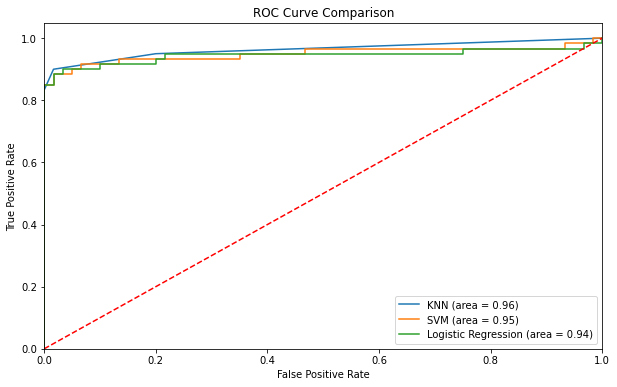

In [3]:
# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 3: Define the models and their hyperparameter grids
models = {
    'KNN': (KNeighborsClassifier(), {
        'model__n_neighbors': [3, 5, 7, 9],  # Prefix with 'model__'
        'model__weights': ['uniform', 'distance']  # Prefix with 'model__'
    }),
    'SVM': (SVC(probability=True), {
        'model__C': [0.01, 0.1, 1, 10, 100],  # Prefix with 'model__'
        'model__kernel': ['linear', 'rbf', 'poly'],  # Prefix with 'model__'
    }),
    'Logistic Regression': (LogisticRegression(solver='liblinear'), {
        'model__C': [0.01, 0.1, 1, 10, 100],  # Prefix with 'model__'
        'model__penalty': ['l1', 'l2']  # Prefix with 'model__'
    })
}

# Initialize a dictionary to hold the results
results = {}

# Step 4: Train each model and evaluate performance
for model_name, (model, param_grid) in models.items():
    print(f"Training {model_name}...")
    
    # Create a pipeline with standardization
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    
    # Use GridSearchCV for hyperparameter tuning
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='recall', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Best model and predictions
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]
    
    # Classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    results[model_name] = {
        'recall': report['1']['recall'],
        'precision': report['1']['precision'],
        'f1-score': report['1']['f1-score'],
        'roc_auc': auc(*roc_curve(y_test, y_prob)[:2]),
        'best_params': grid_search.best_params_  # Store best parameters for ROC plotting
    }
    
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(classification_report(y_test, y_pred))

# Step 5: Display the comparison results
results_df = pd.DataFrame(results).T
print(results_df)

# Step 6: Plot ROC curves for all models
plt.figure(figsize=(10, 6))
for model_name, (model, param_grid) in models.items():
    model_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    
    # Only set parameters relevant to the current model
    best_params = results[model_name]['best_params']  # Retrieve the best parameters stored earlier
    model_pipeline.set_params(**best_params)
    
    model_pipeline.fit(X_train, y_train)
    
    y_prob = model_pipeline.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()


Plotting learning curve for KNN...


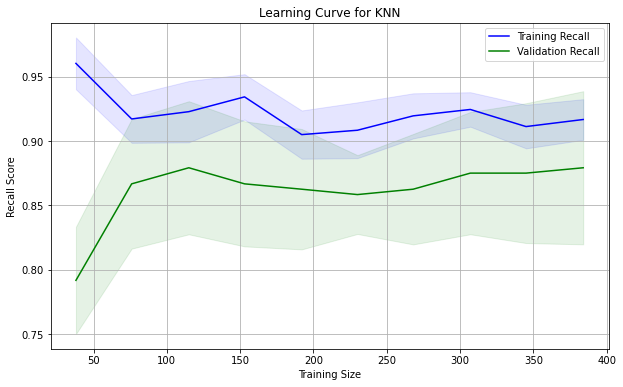

Plotting learning curve for SVM...


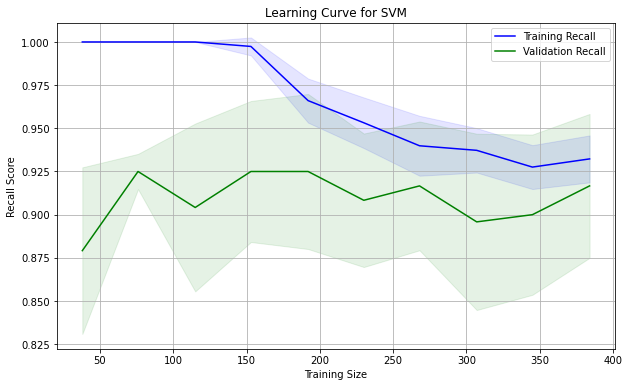

Plotting learning curve for Logistic Regression...


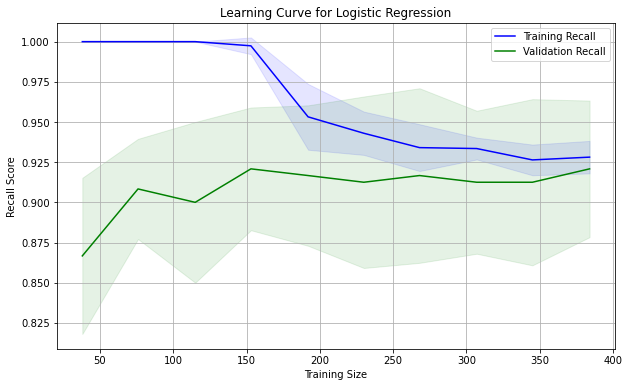

In [4]:
def plot_learning_curve(model, X, y, model_name):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        train_sizes=np.linspace(0.1, 1.0, 10), scoring='recall', n_jobs=-1
    )
    
    # Calculate the mean and standard deviation of training and test scores
    train_scores_mean = train_scores.mean(axis=1)
    test_scores_mean = test_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    test_scores_std = test_scores.std(axis=1)
    
    # Plot learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training Recall', color='blue')
    plt.plot(train_sizes, test_scores_mean, label='Validation Recall', color='green')
    
    # Plot the std deviation as a shaded area
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, 
                     train_scores_mean + train_scores_std, color='blue', alpha=0.1)
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, 
                     test_scores_mean + test_scores_std, color='green', alpha=0.1)

    plt.title(f'Learning Curve for {model_name}')
    plt.xlabel('Training Size')
    plt.ylabel('Recall Score')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# After training each model, plot learning curves
for model_name, (model, param_grid) in models.items():
    print(f"Plotting learning curve for {model_name}...")
    
    # Create a pipeline with standardization
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    
    # Fit the model to get it trained
    pipeline.fit(X_train, y_train)
    
    # Plot learning curve
    plot_learning_curve(pipeline, X_train, y_train, model_name)


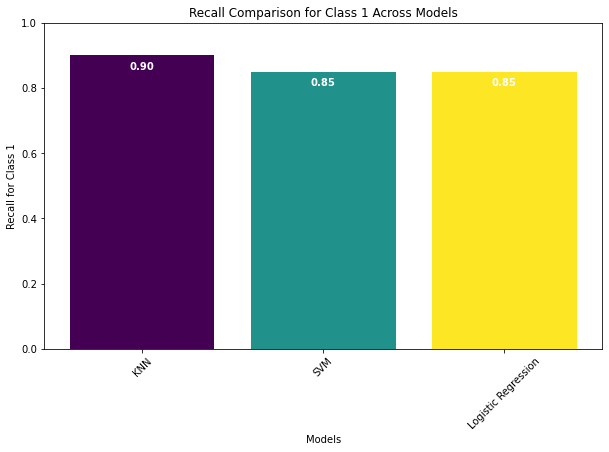

In [5]:
# Extract model names and recall scores for class '1'
model_names = list(results.keys())
recall_scores = [results[model_name]['recall'] for model_name in model_names]
colors = plt.cm.viridis(np.linspace(0, 1, len(model_names)))  # Use a colormap for different colors

# Plotting the bar graph
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, recall_scores, color=colors)
plt.xlabel('Models')
plt.ylabel('Recall for Class 1')
plt.title('Recall Comparison for Class 1 Across Models')
plt.xticks(rotation=45)
plt.ylim(0, 1)  # Recall values are between 0 and 1

# Add the numeric recall values on top of each bar
for bar, score in zip(bars, recall_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05,
             f'{score:.2f}', ha='center', va='bottom', color='white', fontweight='bold')

plt.show()

In [6]:
print(recall_scores)

[0.85, 0.8833333333333333, 0.85]
